In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import sympy as sy

In [2]:
sy.init_printing()

# Вспомогательные функции

In [20]:
def linear_func(x, k):
    return k*x

class linear_func_print:
    def __init__(self, y="y", x="x"):
        self.y = y
        self.x = x


    def get(self, k, b = None, prec = 3):
        form = "{0:0." + str(prec) + "f}"
        return rf"${self.y} = {form.format(k)} \cdot {self.x}" + (fr" + {form.format(b)}" if b is not None else "$")

In [25]:
def plot(x, y, function=linear_func, function_tamplate=None, xerror=None, yerror=None, ejects=None, xlabel="", ylabel="", figsize=(12, 6), title="",
         dots_legend="", approx_legend="", name="graph", precision_print=3):
    '''
    Строит график и аппроксимирует его функцией


    x: массив иксов

    y: массив игриков

    function: функция, которой аппроксимируем, если передать None, то не аппроксимируем

    xerror: массив погрешностей иксов

    yerror: массив погрешностей игриков

    ejects: список индексов точек, которые считаем выбросами (их выбрасываем)

    xlabel: название оси x

    ylabel: название оси y

    figsize: размер графика

    title: название графика

    dots_legend: Подпись для точек

    approx_legend: Подпись для аппроксимации

    name: имя под которым сохраним график, если передать None, то не сохраним

    return popt -- параметры функции
    '''
    if ejects is not None:
        ejects = set(ejects)
    assert len(x) == len(y), "x and y must be the same size"

    if function is not None and ejects is not None:
        x_new, y_new = [], []
        for i in range(len(x)):
            if i not in ejects:
                x_new.append(x[i])
                y_new.append(y[i])
    else:
        x_new, y_new = x, y

    if function is not None:
        popt, pcov = curve_fit(function, xdata=x_new, ydata=y_new)

        x_model = np.linspace(min(x), max(x), 1000)
        y_model = function(x_model, *popt)

    
    plt.figure(figsize=figsize)
    plt.grid(True, linestyle="--")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    if xerror is not None and yerror is not None:
        plt.errorbar(x, y, yerr=yerror, xerr=xerror, fmt="+r")
    else:
        plt.plot(x, y, "+r", label=dots_legend)

    if function is not None:
        leg = approx_legend
        if function_tamplate is not None:
            leg += " " + function_tamplate.get(*popt, prec=precision_print)
        plt.plot(x_model, y_model, color="blue", label=leg)
    plt.legend()
    if name is not None:
        plt.savefig(f"{name}.pdf", format="pdf")

    return popt, pcov

In [5]:
def get_sigma(formula, sigmas):
    sigma_res = 0
    for symb in formula.free_symbols:
        if symb in sigmas.keys():
            sigma_res += formula.diff(symb) ** 2 * sigmas[symb]**2
    return sy.sqrt(sigma_res)

In [6]:
def calc_random_error(data):
    return np.sqrt(
            np.sum(np.square(data - np.mean(data)))
        ) / np.sqrt(len(data) - 1)

# Считывание данных и предварительная обработка

In [7]:
table_name = "5_1.ods"

# Путкт 2

In [8]:
p2_data = pd.read_excel(table_name, engine="odf", sheet_name="2")
p2_data


,number,t,closed,speed_closed,opened,speed_open
0,1,20,1123,56.15,286020,14301.00
1,2,20,1086,54.30,287013,14350.65
2,3,20,726,36.30,287875,14393.75


In [9]:
print(f"Скорость со свинцовой пробкой: {np.mean(p2_data["speed_closed"]):.0f} частиц/с")
print(f"Скорость без свинцовой пробки: {np.mean(p2_data["speed_open"]):.0f} частиц/с")

Скорость со свинцовой пробкой: 49 частиц/с
Скорость без свинцовой пробки: 14348 частиц/с


# Пункт 3

## Измерение фона

In [10]:
noise_data = pd.read_excel(table_name, engine="odf", sheet_name="noise")
noise_data

,number,N,"t, s",speed,sigma
0,1,5690.0,150.0,37.933333,194.243066
1,2,7227.0,150.0,48.180000,13.619380
2,3,7595.0,150.0,50.633333,1.530444
3,4,9060.0,180.0,50.333333,2.362711
4,5,9744.0,180.0,54.133333,5.120666
5,6,10093.0,180.0,56.072222,17.654936
6,avg,NaN,NaN,51.870444,2.838596


In [11]:
noise_value = np.mean(noise_data["speed"])
noise_error = calc_random_error(noise_data["speed"])

print(f"Фоновое излучение: {noise_value:.0f} +- {noise_error:.0f} частиц/с")

Фоновое излучение: 50 +- 6 частиц/с


## Измерение без образцов

In [12]:
empty_data = pd.read_excel(table_name, engine="odf", sheet_name="empty")
empty_data

,number,N,"t, s",speed,sigma,Unnamed: 5,speed.1,sigma.1
0,1.0,360522.0,25.0,14420.880000,29.738844,NaN,14374.462889,39.684402
1,2.0,359744.0,25.0,14389.760000,1337.608711,NaN,NaN,NaN
2,3.0,361709.0,25.0,14468.360000,1766.240711,NaN,NaN,NaN
3,NaN,NaN,NaN,14426.333333,39.582750,NaN,NaN,NaN


In [13]:
empty_value = np.mean(empty_data["speed"])
empty_error = calc_random_error(empty_data["speed"])

print(f"Излучение без образцов: {empty_value:.0f} +- {empty_error:.0f} частиц/с")

Излучение без образцов: 14426 +- 32 частиц/с


## Измерение материалов

$$ \mu = \cfrac{1}{l} \ln{\cfrac{N_0}{N}} $$

$$ \ln{\cfrac{N_0}{N}} = \mu l $$

$\sigma_{log} = \sqrt{\left(\cfrac{\sigma_N}{N}\right)^2 + \left(\cfrac{\sigma_{N_0}}{N_0}\right)^2}$

In [14]:
Al_data = pd.read_excel(table_name, engine="odf", sheet_name="Al")
Al_data

,N,l,sigma_l,speed_raw,sigma_raw,speed,sigma,LogN,sigma_log,mu
0,1,2,0.015,5913.463889,32.283966,5861.593444,32.408519,0.389576,0.006180,0.194788
1,3,6,0.045,1469.177778,10.506945,1417.307333,10.883635,1.006128,0.008160,0.167688
2,5,10,0.075,250.471667,1.887975,198.601222,3.409117,1.859610,0.017386,0.185961


In [21]:
f_print = linear_func_print(y=r"\ln{\frac{N_0}{N}}", x="l")

Errors: [0.00584445]


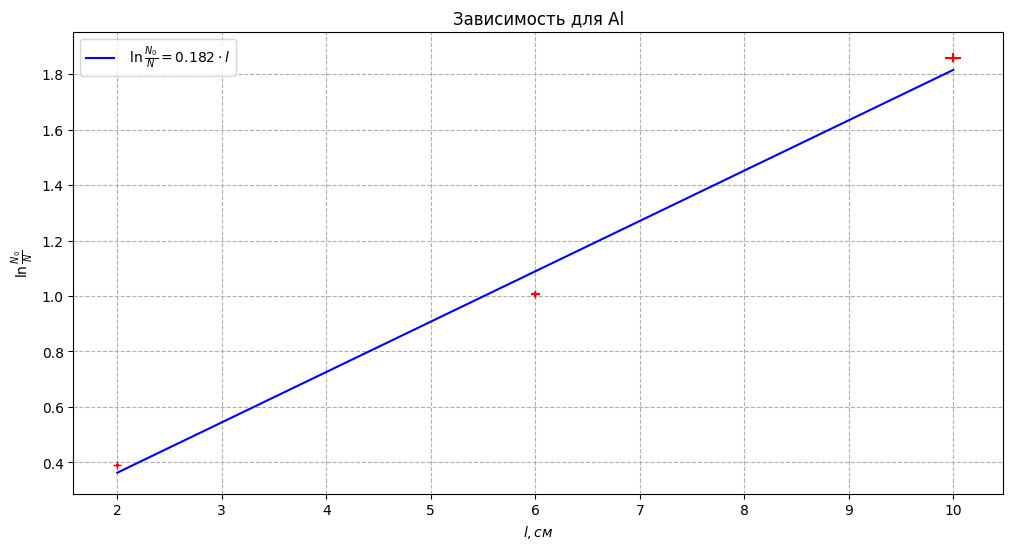

In [26]:
popt, pcov = plot(Al_data["l"], Al_data["LogN"], linear_func, xerror=Al_data["sigma_l"], yerror=Al_data["sigma_log"],
            xlabel=r"$l, см$", ylabel=r"$\ln{\frac{N_0}{N}}$", name="graph_Al", title="Зависимость для Al", 
            dots_legend="Экспериментальные точки", function_tamplate=f_print)

perr = np.sqrt(np.diag(pcov))
print("Errors:", perr)

In [16]:
Fe_data = pd.read_excel(table_name, engine="odf", sheet_name="Fe")
Fe_data

,N,l,sigma_l,speed_raw,sigma_raw,speed,sigma,LogN,sigma_log,mu
0,1,1.0225,0.022361,7517.041667,11.113362,7465.171222,11.470154,0.284552,0.003160,0.278290
1,3,3.0675,0.067082,2591.800000,9.810452,2539.929556,10.212864,0.752770,0.004877,0.245402
2,4,4.0900,0.089443,1509.687500,NaN,1457.817056,2.838596,0.993889,0.003378,0.243005


Errors: [0.00474839]


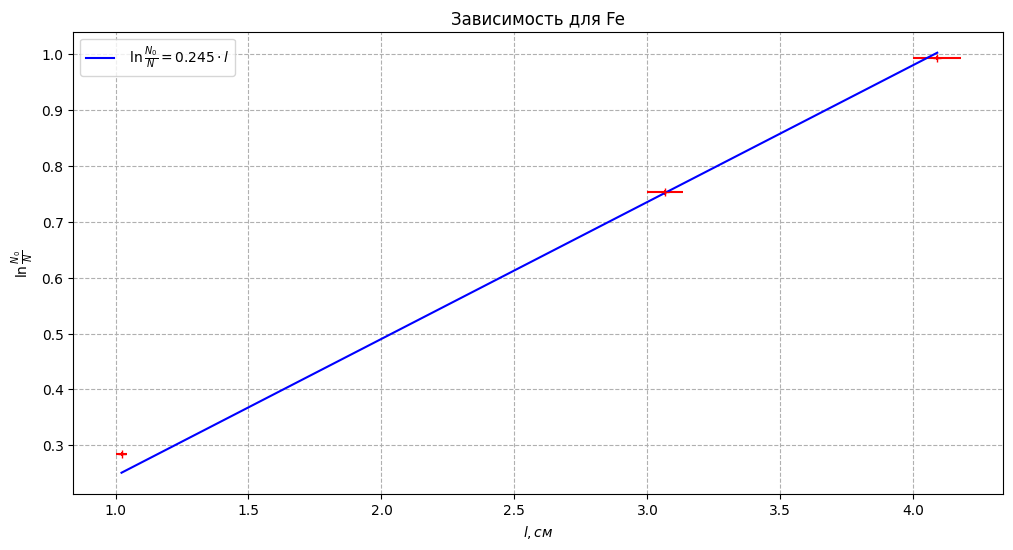

In [31]:
popt, pcov = plot(Fe_data["l"], Fe_data["LogN"], linear_func, xerror=Fe_data["sigma_l"], yerror=Fe_data["sigma_log"],
            xlabel=r"$l, см$", ylabel=r"$\ln{\frac{N_0}{N}}$", name="graph_Fe", title="Зависимость для Fe", 
            dots_legend="Экспериментальные точки", function_tamplate=f_print)

perr = np.sqrt(np.diag(pcov))
print("Errors:", perr)

In [18]:
Pb_data = pd.read_excel(table_name, engine="odf", sheet_name="Pb")
Pb_data

,N,l,sigma_l,speed_raw,sigma_raw,speed,sigma,LogN,sigma_log,mu
0,1,0.475,0.071937,7975.408333,21.637468,7923.537889,21.822869,0.258672,0.003900,0.544574
1,3,1.425,0.215812,2888.491667,NaN,2836.621222,2.838596,0.704790,0.002937,0.494590
2,5,2.375,0.359687,1017.744444,NaN,965.874000,2.838596,1.172671,0.004032,0.493756
3,6,2.850,0.431625,642.433333,NaN,590.562889,2.838596,1.386325,0.005543,0.486430


Errors: [0.00429355]


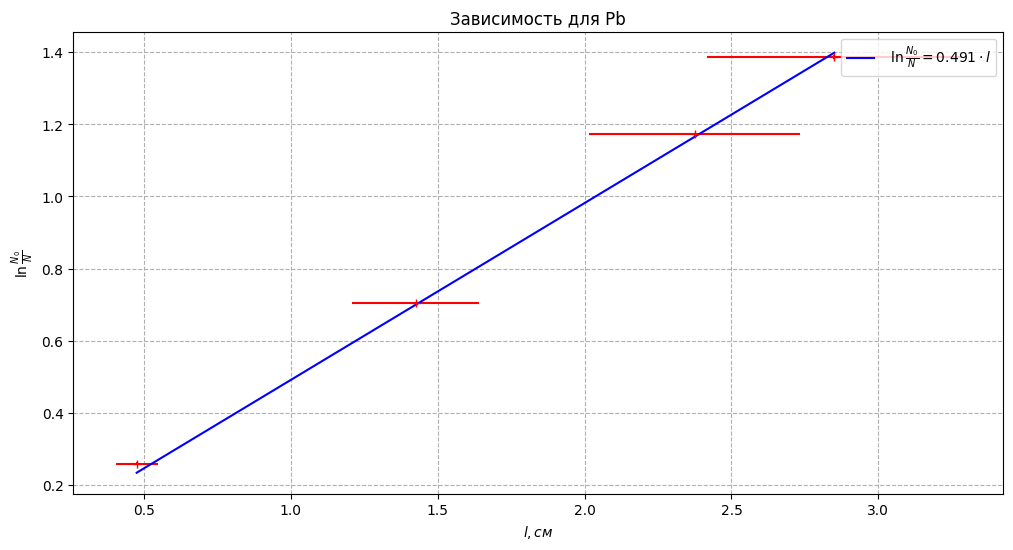

In [30]:
popt, pcov = plot(Pb_data["l"], Pb_data["LogN"], linear_func, xerror=Pb_data["sigma_l"], yerror=Pb_data["sigma_log"],
            xlabel=r"$l, см$", ylabel=r"$\ln{\frac{N_0}{N}}$", name="graph_Pb", title="Зависимость для Pb", 
            dots_legend="Экспериментальные точки", function_tamplate=f_print)

perr = np.sqrt(np.diag(pcov))
print("Errors:", perr)